In [ ]:
# VCF FILE #

import gzip
import pandas as pd

## Read the ClinVar VCF file
variants = []

with gzip.open(r"C:\Users\NAILA\Documents\variant_project\data", 'rt') as f:
    for line in f:
        if line.startswith('##'):
            continue  ### skip metadata
        if line.startswith('#CHROM'):
            headers = line.strip().lstrip('#').split('\t')
            continue
        variants.append(line.strip().split('\t'))

## View the dataset
df = pd.DataFrame(variants, columns=headers)
print(df.shape)
df.head()

(4389319, 8)


,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO
0,1,66926,3385321,AG,A,.,.,ALLELEID=3544463;CLNDISDB=Human_Phenotype_Onto...
1,1,69134,2205837,A,G,.,.,ALLELEID=2193183;CLNDISDB=MedGen:CN169374;CLND...
2,1,69241,4562067,C,T,.,.,ALLELEID=4679177;CLNDISDB=MedGen:CN169374;CLND...
3,1,69308,3925305,A,G,.,.,ALLELEID=4039319;CLNDISDB=MedGen:CN169374;CLND...
4,1,69314,3205580,T,G,.,.,ALLELEID=3374047;CLNDISDB=MedGen:CN169374;CLND...


In [3]:
# EXTRACT THE USEFUL INFORMATION #
import re

def parse_info(info_str):
    info_dict = {}
    for field in info_str.split(';'):
        if '=' in field:
            key, value = field.split('=', 1)
            info_dict[key] = value
    return info_dict

# Parse INFO column
info_parsed = df['INFO'].apply(parse_info)

# Extract the fields we care about
df['CLNSIG'] = info_parsed.apply(lambda x: x.get('CLNSIG', None))        ### Pathogenicity label
df['CLNDN'] = info_parsed.apply(lambda x: x.get('CLNDN', None))          ### Disease name
df['AF_ESP'] = info_parsed.apply(lambda x: x.get('AF_ESP', None))        ### Allele frequency
df['CLNVC'] = info_parsed.apply(lambda x: x.get('CLNVC', None))          ### Variant type

print(df['CLNSIG'].value_counts())

CLNSIG
Uncertain_significance                          2292126
Likely_benign                                   1074777
Benign                                           208797
Pathogenic                                       184286
Conflicting_classifications_of_pathogenicity     162594
                                                 ...   
Pathogenic/Pathogenic,_low_penetrance|other           1
VUS-low                                               1
Pathogenic/Likely_pathogenic|association              1
Benign|confers_sensitivity                            1
confers_sensitivity|other                             1
Name: count, Length: 98, dtype: int64


In [ ]:
# CLASSIFYING THE LABELS
def simplify_label(clnsig):
    if clnsig is None:
        return None
    clnsig = clnsig.lower()
    if 'pathogenic' in clnsig and 'conflicting' not in clnsig:
        return 'Pathogenic'
    elif 'benign' in clnsig and 'conflicting' not in clnsig:
        return 'Benign'
    elif 'uncertain' in clnsig or 'conflicting' in clnsig:
        return 'VUS'
    else:
        return None

df['LABEL'] = df['CLNSIG'].apply(simplify_label)

print(df['LABEL'].value_counts())
print(f"\nTotal labelled variants: {df['LABEL'].notna().sum():,}")

LABEL
VUS           2455002
Benign        1347269
Pathogenic     331202
Name: count, dtype: int64

Total labelled variants: 4,133,473


In [5]:
# BUILD THE FEATURE MATRIX

## Keep only Pathogenic and Benign for training
train_df = df[df['LABEL'].isin(['Pathogenic', 'Benign'])].copy()

# Convert ALT/REF to length difference 
train_df['REF_len'] = train_df['REF'].str.len()
train_df['ALT_len'] = train_df['ALT'].str.len()
train_df['len_diff'] = train_df['ALT_len'] - train_df['REF_len']

# Variant type encoding
train_df['CLNVC_encoded'] = train_df['CLNVC'].astype('category').cat.codes

# Chromosome encoding
train_df['CHROM_encoded'] = pd.to_numeric(train_df['CHROM'], errors='coerce').fillna(23)

# Position as numeric
train_df['POS'] = pd.to_numeric(train_df['POS'])

# Binary label
train_df['TARGET'] = (train_df['LABEL'] == 'Pathogenic').astype(int)

print(train_df[['REF_len', 'ALT_len', 'len_diff', 'CLNVC_encoded', 'CHROM_encoded', 'TARGET']].head())
print(f"\nTraining set size: {len(train_df):,}")

    REF_len  ALT_len  len_diff  CLNVC_encoded  CHROM_encoded  TARGET
1         1        1         0              7            1.0       0
21        1       10         9              3            1.0       0
27        1        1         0              7            1.0       0
30        1        1         0              7            1.0       0
32        1        1         0              7            1.0       0

Training set size: 1,678,471


In [6]:
# RANDOM FOREST CLASSIFIER

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

## Sample to keep it manageable (100k variants)
sample_df = train_df.sample(n=100000, random_state=42)

## Features and target
features = ['REF_len', 'ALT_len', 'len_diff', 'CLNVC_encoded', 'CHROM_encoded', 'POS']
X = sample_df[features]
y = sample_df['TARGET']

## Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Train the model
print("Training model... 🚀")
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

## Evaluate
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Benign', 'Pathogenic']))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

Training model... 🚀

📊 Classification Report:
              precision    recall  f1-score   support

      Benign       0.88      0.87      0.87     16026
  Pathogenic       0.49      0.51      0.50      3974

    accuracy                           0.80     20000
   macro avg       0.68      0.69      0.69     20000
weighted avg       0.80      0.80      0.80     20000

ROC-AUC Score: 0.7774


In [7]:
# IMPROVING THE PATHOGENIC CLASSIFICATION

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

## Balance the classes by equal sampling
benign_sample = train_df[train_df['TARGET'] == 0].sample(n=50000, random_state=42)
pathogenic_sample = train_df[train_df['TARGET'] == 1].sample(n=50000, random_state=42)
balanced_df = pd.concat([benign_sample, pathogenic_sample])

features = ['REF_len', 'ALT_len', 'len_diff', 'CLNVC_encoded', 'CHROM_encoded', 'POS']
X = balanced_df[features]
y = balanced_df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training balanced model... 🚀")
rf_balanced = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_balanced.fit(X_train, y_train)

y_pred = rf_balanced.predict(X_test)
y_prob = rf_balanced.predict_proba(X_test)[:, 1]

print("\n📊 Balanced Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Benign', 'Pathogenic']))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

Training balanced model... 🚀

📊 Balanced Classification Report:
              precision    recall  f1-score   support

      Benign       0.72      0.69      0.70     10035
  Pathogenic       0.70      0.73      0.71      9965

    accuracy                           0.71     20000
   macro avg       0.71      0.71      0.71     20000
weighted avg       0.71      0.71      0.71     20000

ROC-AUC Score: 0.7921


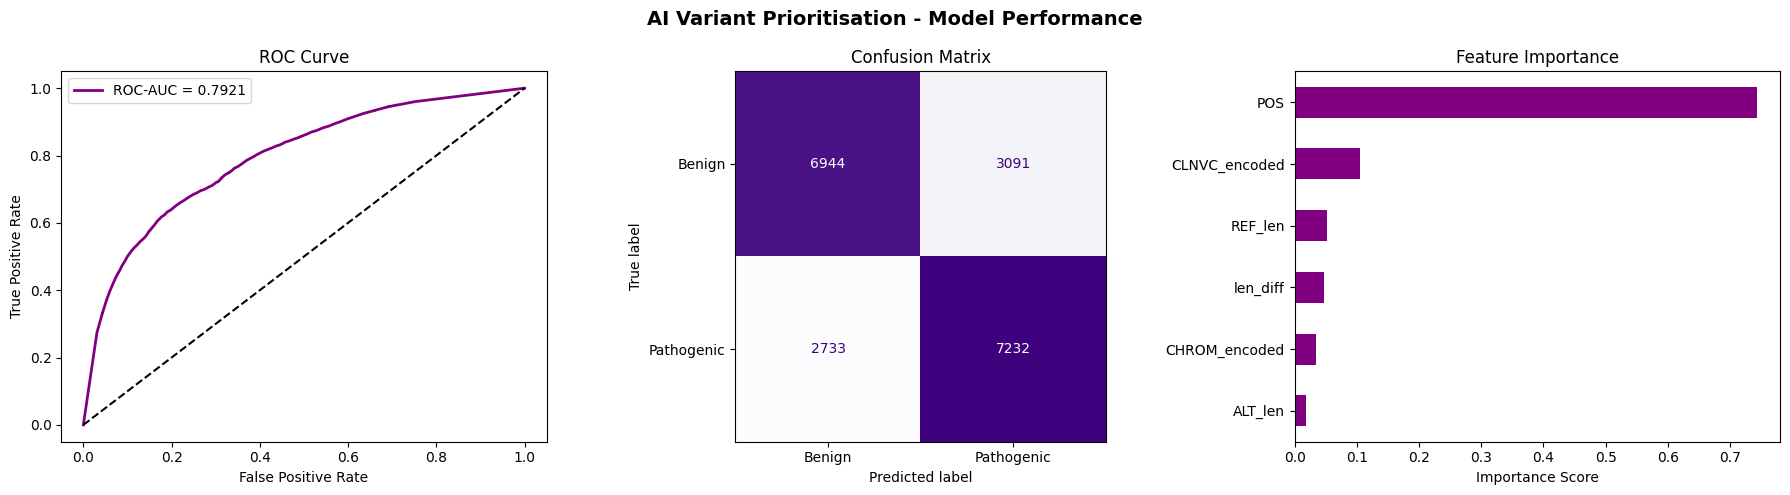

Plot saved to results folder!


In [8]:
# DATA VISUALISATION

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, ConfusionMatrixDisplay

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('AI Variant Prioritisation - Model Performance', fontsize=14, fontweight='bold')

## 1. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
axes[0].plot(fpr, tpr, color='purple', lw=2, label=f'ROC-AUC = 0.7921')
axes[0].plot([0,1], [0,1], 'k--')
axes[0].set_title('ROC Curve')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend()

## 2. Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, 
    display_labels=['Benign', 'Pathogenic'],
    colorbar=False, ax=axes[1], cmap='Purples')
axes[1].set_title('Confusion Matrix')

## 3. Feature Importance
feat_importance = pd.Series(rf_balanced.feature_importances_, index=features)
feat_importance.sort_values().plot(kind='barh', ax=axes[2], color='purple')
axes[2].set_title('Feature Importance')
axes[2].set_xlabel('Importance Score')

plt.tight_layout()
plt.savefig(r'C:\Users\NAILA\Documents\variant_project\results\model_performance.png', dpi=150)
plt.show()
print("Plot saved to results folder!")

In [9]:
# SCORING THE VUS VARIANTS

## Prepare VUS variants for scoring
vus_df = df[df['LABEL'] == 'VUS'].copy()

vus_df['REF_len'] = vus_df['REF'].str.len()
vus_df['ALT_len'] = vus_df['ALT'].str.len()
vus_df['len_diff'] = vus_df['ALT_len'] - vus_df['REF_len']
vus_df['CLNVC_encoded'] = vus_df['CLNVC'].astype('category').cat.codes
vus_df['CHROM_encoded'] = pd.to_numeric(vus_df['CHROM'], errors='coerce').fillna(23)
vus_df['POS'] = pd.to_numeric(vus_df['POS'])

## Score VUS variants
X_vus = vus_df[features]
vus_df['pathogenic_score'] = rf_balanced.predict_proba(X_vus)[:, 1]

## Rank by score
vus_ranked = vus_df[['CHROM', 'POS', 'REF', 'ALT', 'CLNDN', 'pathogenic_score']].sort_values(
    'pathogenic_score', ascending=False)

print(f"Total VUS scored: {len(vus_ranked):,}")
print("\n Top 20 High-Risk VUS (most likely pathogenic):")
print(vus_ranked.head(20).to_string())

Total VUS scored: 2,455,002

 Top 20 High-Risk VUS (most likely pathogenic):
        CHROM        POS     REF ALT                                                                                                 CLNDN  pathogenic_score
663753      2  178671132      GT   G                                                                                        Cardiomyopathy               1.0
2240620    10   87894122       T  TG                                                               Hereditary_cancer-predisposing_syndrome               1.0
2240413    10   87894009  TAACTA   T                                                                         PTEN_hamartoma_tumor_syndrome               1.0
2240659    10   87925508       T   G         Glioma_susceptibility_2|PTEN_hamartoma_tumor_syndrome|Hereditary_cancer-predisposing_syndrome               1.0
2240665    10   87925510       A   G                                                                         PTEN_hamartoma_tumor_syndrome

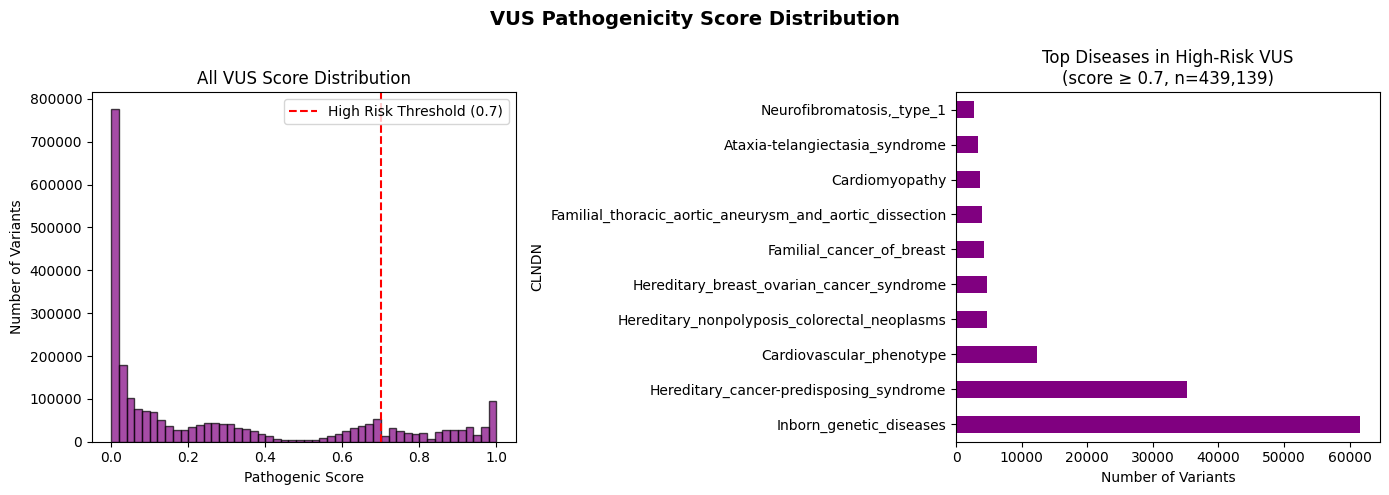


 High-risk VUS (score ≥ 0.7): 439,139
Results saved


In [ ]:
# SAVE RESULTS

## Save ranked VUS to CSV
vus_ranked.to_csv(r'C:\Users\NAILA\Documents\variant_project\results\vus_prioritised.csv', index=False)

## Plot score distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('VUS Pathogenicity Score Distribution', fontsize=14, fontweight='bold')

## Score distribution
axes[0].hist(vus_ranked['pathogenic_score'], bins=50, color='blue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Pathogenic Score')
axes[0].set_ylabel('Number of Variants')
axes[0].set_title('All VUS Score Distribution')
axes[0].axvline(x=0.7, color='red', linestyle='--', label='High Risk Threshold (0.7)')
axes[0].legend()

## Top diseases in high risk VUS
high_risk = vus_ranked[vus_ranked['pathogenic_score'] >= 0.7]
top_diseases = high_risk['CLNDN'].str.split('|').explode().str.strip()
top_diseases = top_diseases[top_diseases != 'not_provided']
top_diseases = top_diseases[top_diseases != 'not_specified']
top_diseases.value_counts().head(10).plot(kind='barh', ax=axes[1], color='blue')
axes[1].set_title(f'Top Diseases in High-Risk VUS\n(score ≥ 0.7, n={len(high_risk):,})')
axes[1].set_xlabel('Number of Variants')

plt.tight_layout()
plt.savefig(r'C:\Users\NAILA\Documents\variant_project\results\vus_distribution.png', dpi=150)
plt.show()
print(f"\n High-risk VUS (score ≥ 0.7): {len(high_risk):,}")
print(f"Results saved")